In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import texttable as tt
from sklearn import model_selection 
from sklearn import linear_model 
from sklearn import preprocessing

## Loading data

In [2]:
data = pd.read_csv('data/train.csv', index_col='PassengerId')

## Preprocessing

### removing unhelpful columns

First we need to preprocess the data remove unique data like the name and ticket number that may not be useful in predicting the target variable: i.e. did the passenger survive.

Here we choose to remove the columns : 
- name
- ticket number
- Cabin

In [3]:
data[0:5]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
del data.index.name # lets also remove this row with just the name on it to make things easier later

In [5]:
data[0:5]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data = data.drop(labels=['Name', 'Ticket', 'Cabin'], axis=1) # dropping name, ticket and Cabin columns

In [7]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Dealing with NaN values

Now we need to treat NaN values somehow as they can have break our learning algorithm

In [8]:
num_dropped_removing_Nans = len(data) - len(data.dropna()) # calculate number of entries we would drop if we dropped all entries containing NaN
percent_dropped_removing_Nans = 100*(len(data) - len(data.dropna()))/len(data)

print(num_dropped_removing_Nans) # dropping all rows with NaNs in them drops 708 examples
print("Percent dropped by removing NaNs: {:.2f}%".format(percent_dropped_removing_Nans))

179
Percent dropped by removing NaNs: 20.09%


Removing entries with NaNs is not a good option as it leads to loss of almost 20% of the data, we should find another way to deal with these NaN entries.

Lets take a look at some of our NaN entries

In [9]:
data_temp = data[data.isnull().any(axis=1)] # get any row that has a NaN in it
data_temp[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
6,0,3,male,NaN,0,0,8.4583,Q
18,1,2,male,NaN,0,0,13.0000,S
20,1,3,female,NaN,0,0,7.2250,C
27,0,3,male,NaN,0,0,7.2250,C
29,1,3,female,NaN,0,0,7.8792,Q


Our options are to replace NaNs with:
- A constant value that has meaning within the domain, such as 0, distinct from all other values.
- A value from another randomly selected record.
- A mean, median or mode value for the column.
- A value estimated by another predictive model.

As a first approach lets try to replace NaNs with the mean in their columns

In [10]:
data_nans_replaced = data.fillna(data.mean()) # fill in NaNs with mean of thier columns

And lets look what the NaNs were replaced with 

In [11]:
data_temp = data_nans_replaced[data.isnull().any(axis=1)] # get rows of the replaced data where the rows used to contain NaNs
data_temp[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
6,0,3,male,29.699118,0,0,8.4583,Q
18,1,2,male,29.699118,0,0,13.0000,S
20,1,3,female,29.699118,0,0,7.2250,C
27,0,3,male,29.699118,0,0,7.2250,C
29,1,3,female,29.699118,0,0,7.8792,Q


Repacing these in this way may cause some issues, but we will go forward with this method for now and see how it affects the performance of our learning algorithm later by comparing performance of the learning algorithm with some of the other methods to replace NaN values.

In [12]:
data = data_nans_replaced # replace data with data where we have replaced NaNs with mean values

Lets check we really got rid of all the NaNs

In [13]:
num_dropped_removing_Nans = len(data) - len(data.dropna())
percent_dropped_removing_Nans = 100*(len(data) - len(data.dropna()))/len(data)

print(num_dropped_removing_Nans) # dropping all rows with NaNs in them drops 708 examples
print("Percent dropped by removing NaNs: {:.2f}%".format(percent_dropped_removing_Nans))

2
Percent dropped by removing NaNs: 0.22%


We didn't! Good job we checked, lets take a look at what NaN entries are left.

In [14]:
data_temp = data[data.isnull().any(axis=1)]
data_temp

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
62,1,1,female,38.0,0,0,80.0,NaN
830,1,1,female,62.0,0,0,80.0,NaN


There are just 2 entries where it is unknown if the person embarked, we will remove these 2 rows as they are a relatively insignificant fraction of our data.

In [15]:
data = data.dropna()

In [16]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Encoding categorical features

We now need to encode the categorical features into many binary features. This is nessesary because of the way the algorithm interprets numbers. If we have a categorical feature that takes values 0, 1, 2, 3, 4 it assumes the higher numbers are 'better' (e.g. 4>3) even though they are arbitrary encodings, because ultimately it is calculating values/weights/parameters to be multiplied by these feature variables to give a term which enters into the linear regression. One common way to deal with this is one-hot-encoding, where a feature N takes values 0, 1, 2 for example we would generate 3 features which takes binary values 0 or 1. An example is shown below

We have the original feature data:

| Entry        | N          |
| ------------ |:----------:|
| 0            | 1          | 
| 1            | 2          |
| 2            | 0          |
| 3            | 1          |
| 4            | 2          |
| 5            | 0          |

Which when encoded becomes:

| Entry        | N==0       | N==1       | N==2       |
| ------------ |:----------:|:----------:|:----------:|
| 0            | 0          | 1          | 0          | 
| 1            | 0          | 0          | 1          | 
| 2            | 1          | 0          | 0          | 
| 3            | 0          | 1          | 0          | 
| 4            | 0          | 0          | 1          | 
| 5            | 1          | 0          | 0          | 


Here we need some insight into the data. The categorical features are:
- pclass : the Ticket class
- sex : the gender/sex of the passenger 
- embarked : the port where the passenger embarked from
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

We encode sex with 0 or 1 and save the mapping we have used to a dictionary so we now how to transform new data we get in future.

In [17]:
data.Sex[0:5]

1      male
2    female
3    female
4    female
5      male
Name: Sex, dtype: object

In [18]:
le_sex = preprocessing.LabelEncoder()
le_sex.fit(data.Sex.unique()) # fits a value to each unique integer value of the feature variable sex
data['Sex_numeric'] = le_sex.transform(data.Sex) # transform the data from labels to numeric

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [19]:
data.Sex_numeric[0:5] # values are now encoded numerically

1    1
2    0
3    0
4    0
5    1
Name: Sex_numeric, dtype: int64

In [20]:
le_sex.inverse_transform(data.Sex_numeric[0:5]) # and the label encoder lets us reverse this if need be

array(['male', 'female', 'female', 'female', 'male'], dtype=object)

In [21]:
le_Embarked = preprocessing.LabelEncoder()
le_Embarked.fit(data.Embarked.unique()) # fits a value to each unique integer value of the feature variable sex
data['Embarked_numeric'] = le_Embarked.transform(data.Embarked) # transform the data from labels to numeric

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [22]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_numeric,Embarked_numeric
1,0,3,male,22.0,1,0,7.2500,S,1,2
2,1,1,female,38.0,1,0,71.2833,C,0,0
3,1,3,female,26.0,0,0,7.9250,S,0,2
4,1,1,female,35.0,1,0,53.1000,S,0,2
5,0,3,male,35.0,0,0,8.0500,S,1,2


Pclass is already numeric and takes values 1 -> 3

In [23]:
data.Pclass.unique()

array([3, 1, 2])

In [24]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_numeric,Embarked_numeric
1,0,3,male,22.0,1,0,7.2500,S,1,2
2,1,1,female,38.0,1,0,71.2833,C,0,0
3,1,3,female,26.0,0,0,7.9250,S,0,2
4,1,1,female,35.0,1,0,53.1000,S,0,2
5,0,3,male,35.0,0,0,8.0500,S,1,2


Now that Pclass and Embarked take numeric integer values we can now apply the one-hot-encoding to generate binary features.

**Method 1 of one-hot-encoding**

In [25]:
enc_Embarked = preprocessing.OneHotEncoder()
encoded_column_vector = data.Embarked_numeric.values.reshape(-1,1) # gets numeric embarked data and rehsapes it to column vector

Embarked_one_hot_encoded = enc_Embarked.fit_transform(encoded_column_vector).toarray() # we now apply a fit and transform step to the data simultaneous which fits the one-hot-encoder and transforms the data to one-hot-encoded data

dfOneHot_Encoded = pd.DataFrame(Embarked_one_hot_encoded, 
columns = ["Embarked_"+le_Embarked.inverse_transform(int(i)) for i in range(Embarked_one_hot_encoded.shape[1])],
index=data.index
) # we now construct a dataframe out of this one-hot-encoded data

In [26]:
data = pd.concat([data, dfOneHot_Encoded], axis=1)
# we now add our one-hot-encoded Embarked features

In [27]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_numeric,Embarked_numeric,Embarked_C,Embarked_Q,Embarked_S
1,0,3,male,22.0,1,0,7.2500,S,1,2,0.0,0.0,1.0
2,1,1,female,38.0,1,0,71.2833,C,0,0,1.0,0.0,0.0
3,1,3,female,26.0,0,0,7.9250,S,0,2,0.0,0.0,1.0
4,1,1,female,35.0,1,0,53.1000,S,0,2,0.0,0.0,1.0
5,0,3,male,35.0,0,0,8.0500,S,1,2,0.0,0.0,1.0


**Method 2 of one-hot-encoding**

In [28]:
Pclass_lb = preprocessing.LabelBinarizer()
Pclass_one_hot_encoded = Pclass_lb.fit_transform(data.Pclass.values)

In [29]:
dfOneHot_Encoded = pd.DataFrame(Pclass_one_hot_encoded, 
columns = ["Pclass_"+str(int(i+1)) for i in range(Pclass_one_hot_encoded.shape[1])],
index=data.index
) # we now construct a dataframe out of this one-hot-encoded data


In [30]:
data = pd.concat([data, dfOneHot_Encoded], axis=1)
# we now add our one-hot-encoded Embarked features

In [31]:
data[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_numeric,Embarked_numeric,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
1,0,3,male,22.0,1,0,7.2500,S,1,2,0.0,0.0,1.0,0,0,1
2,1,1,female,38.0,1,0,71.2833,C,0,0,1.0,0.0,0.0,1,0,0
3,1,3,female,26.0,0,0,7.9250,S,0,2,0.0,0.0,1.0,0,0,1
4,1,1,female,35.0,1,0,53.1000,S,0,2,0.0,0.0,1.0,1,0,0
5,0,3,male,35.0,0,0,8.0500,S,1,2,0.0,0.0,1.0,0,0,1


Now we have finished preprocessing our data we can extract our feature and target varaibles to be used to train, validate and test our learning algorithm.

In [32]:
y = data['Survived']
X = data.drop(['Survived'], 1)

In [33]:
X.drop(labels=['Sex', 'Pclass', 'Embarked', 'Embarked_numeric'], axis=1, inplace=True) # we drop the features that we have one-hot-encoded but not removed yet (we left these in to check the encoding had worked correctly)

In [34]:
X[0:5]

,Age,SibSp,Parch,Fare,Sex_numeric,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
1,22.0,1,0,7.2500,1,0.0,0.0,1.0,0,0,1
2,38.0,1,0,71.2833,0,1.0,0.0,0.0,1,0,0
3,26.0,0,0,7.9250,0,0.0,0.0,1.0,0,0,1
4,35.0,1,0,53.1000,0,0.0,0.0,1.0,1,0,0
5,35.0,0,0,8.0500,1,0.0,0.0,1.0,0,0,1


## [Train, Validation, Test] splitting

Now lets split our pre-processed data into a training set, cross validation set and test set with a 60/20/20 split.

In [35]:
X_temp, X_test, y_temp, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [36]:
X_train, X_cv, y_train, y_cv = model_selection.train_test_split(X_temp, y_temp, train_size=0.75)

/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [37]:
print("Data split is as follows:")
print("-------------------------")
print("train: {} \ncross-validation: {} \ntest: {}".format(X_train.shape[0], X_cv.shape[0], X_test.shape[0]))

Data split is as follows:
-------------------------
train: 533 
cross-validation: 178 
test: 178


## First lets just predict everyone dies, no learning algorithm, to see how that goes

In [38]:
def predict(X):
    return np.zeros(X_test.shape[0])

In [39]:
prediction = predict(X_test)

In [40]:
100*sum(prediction == y_test)/y_test.shape[0]

60.112359550561798

This achieves an accuracy of ~57%, which doesn't seem that bad. But if we now look at the truth table of our target variable vs our prediction we can see the truth, that we are just predicting false all the time.

In [41]:
TruePositives = sum((prediction == y_test) & (y_test == 1))
TrueNegatives = sum((prediction == y_test) & (y_test == 0))
FalsePositives = sum((prediction != y_test) & (prediction == 1))
FalseNegatives = sum((prediction != y_test) & (prediction == 0))

In [42]:
table = tt.Texttable()
table.add_rows([
                ["", "", "Real Value", ""],
                ["", "", "Positive", "Negative"],
                ["Prediction", "Positive", TruePositives, FalsePositives],
                ["", "Negative", FalseNegatives, TrueNegatives],
                ])
print(table.draw() + "\n")

+------------+----------+------------+----------+
|            |          | Real Value |          |
+============+==========+============+==========+
|            |          | Positive   | Negative |
+------------+----------+------------+----------+
| Prediction | Positive | 0          | 0        |
+------------+----------+------------+----------+
|            | Negative | 71         | 107      |
+------------+----------+------------+----------+



In [43]:
PredictedPositives = TruePositives + FalsePositives
Precision = TruePositives/PredictedPositives

ActualPositives = TruePositives + FalseNegatives
Recall = TruePositives/ActualPositives

print("Precision: {}".format(Precision))

print("Recall: {}".format(Recall))

F1score = 2*Precision*Recall/(Precision+Recall)

print("F1score: {}".format(Recall))

Precision: nan
Recall: 0.0
F1score: 0.0


/Users/ajs3g11/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


It is much more obvious from this that our predicting everyone dies is a bad method to predict survival.

## First lets just attempt a basic logistic regression

In [44]:
# We now use scikit learn to fit a regularised logistic regression 
# model with each of the feature variables being linear
# setting fit_intercept=True fits the Theta_0 term - an intercept term

lr_model = linear_model.LogisticRegression(fit_intercept=True)

# we now fit to the training data
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
lr_model.score(X_train, y_train)

0.78986866791744836

We get ~80% accuracy on our training data

We now evaluate our performance on the cross validation data it hasn't seen. We using our cross-validation data instead of our testing data to evaluate the classifier as we are using the cross-validation performance to pick our final algorithm and we don't want to pick an algorithm that happens to work well on the testing data but doesn't generalise well to new data.

In [46]:
lr_model.score(X_cv, y_cv) # this very simple logisitc regression with 

0.8314606741573034

We get ~82.5% accuracy, which is very good, lets look at our truth table, precision, recall and f1score values as well to get a better idea what's going on.

In [47]:
prediction = lr_model.predict(X_cv)

In [48]:
TruePositives = sum((prediction == y_cv) & (y_cv == 1))
TrueNegatives = sum((prediction == y_cv) & (y_cv == 0))
FalsePositives = sum((prediction != y_cv) & (prediction == 1))
FalseNegatives = sum((prediction != y_cv) & (prediction == 0))

In [49]:
table = tt.Texttable()
table.add_rows([
                ["", "", "Real Value", ""],
                ["", "", "Positive", "Negative"],
                ["Prediction", "Positive", TruePositives, FalsePositives],
                ["", "Negative", FalseNegatives, TrueNegatives],
                ])
print(table.draw() + "\n")

+------------+----------+------------+----------+
|            |          | Real Value |          |
+============+==========+============+==========+
|            |          | Positive   | Negative |
+------------+----------+------------+----------+
| Prediction | Positive | 53         | 14       |
+------------+----------+------------+----------+
|            | Negative | 16         | 95       |
+------------+----------+------------+----------+



Looking at our truth table this looks much better than we got just predicting everyone dies.

In [50]:
PredictedPositives = TruePositives + FalsePositives
Precision = TruePositives/PredictedPositives

ActualPositives = TruePositives + FalseNegatives
Recall = TruePositives/ActualPositives

print("Precision: {:.3f}".format(Precision))

print("Recall: {:.3f}".format(Recall))

F1score = 2*Precision*Recall/(Precision+Recall)

print("F1score: {:.3f}".format(F1score))

Precision: 0.791
Recall: 0.768
F1score: 0.779


And we now get a decent precision and recall, although recall is worse, giving us a decent F1score.

### Learning Curve

Lets look at the learning curve for this algorithm:

In [51]:
m_array = range(10, X_train.shape[0], 100)
train_acc_array = []
cv_acc_array = []

for m in m_array:
    lr_model = linear_model.LogisticRegression(fit_intercept=True)
    # we now fit to the training data
    lr_model.fit(X_train.head(m), y_train.head(m)) # training on the first m training data examples
    train_accuracy = lr_model.score(X_train, y_train)
    train_acc_array.append(train_accuracy)
    cv_accuracy = lr_model.score(X_cv, y_cv)
    cv_acc_array.append(cv_accuracy)

train_acc_array = np.array(train_acc_array)
cv_acc_array = np.array(cv_acc_array)

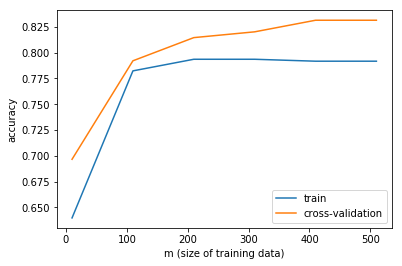

In [52]:
fig, ax = plt.subplots()
ax.plot(m_array, train_acc_array, label='train')
ax.plot(m_array, cv_acc_array, label='cross-validation')
ax.legend()
ax.set_xlabel('m (size of training data)')
ax.set_ylabel('accuracy')